# Imports and GPU configuration

In [2]:
import tensorflow as tf 
import numpy as np
import os
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import pathlib

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

# The Data

In [5]:
BATCH_SIZE = 32
IMG_SIZE = (256, 256)

In [6]:
PATH = 'data'
train_dir = os.path.join(PATH, 'train')
test_dir = os.path.join(PATH, 'test')

In [7]:
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             validation_split=0.2,
                                             subset="training",
                                             seed=42,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 4603 files belonging to 2 classes.
Using 3683 files for training.


In [7]:
class_names = train_dataset.class_names

In [8]:
class_names

['hotdog', 'non_hotdog']

In [8]:
validation_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             validation_split=0.2,
                                             subset="validation",
                                             seed=42,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 4603 files belonging to 2 classes.
Using 920 files for validation.


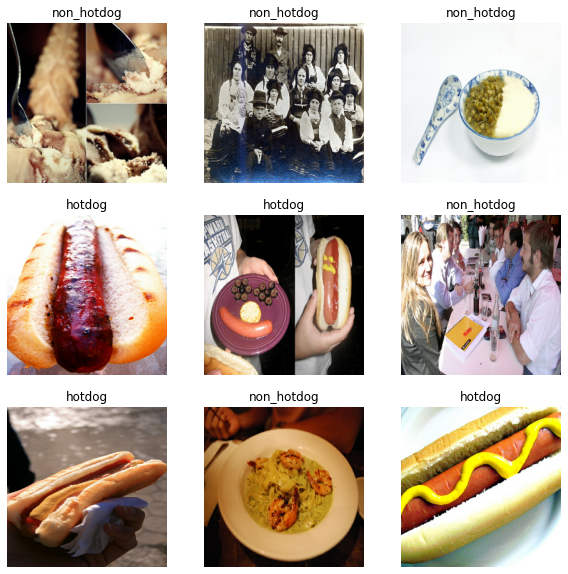

In [22]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [9]:
test_dataset = image_dataset_from_directory(test_dir,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             labels=None,
                                             label_mode=None)

Found 1150 files belonging to 1 classes.


In [10]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Preprocessing

### Data Augmentation

In [11]:
data_augmentation = tf.keras.Sequential(
    [
        preprocessing.RandomFlip("horizontal_and_vertical"),
        preprocessing.RandomRotation(0.3),
        preprocessing.RandomZoom(0.3)
    ]
)

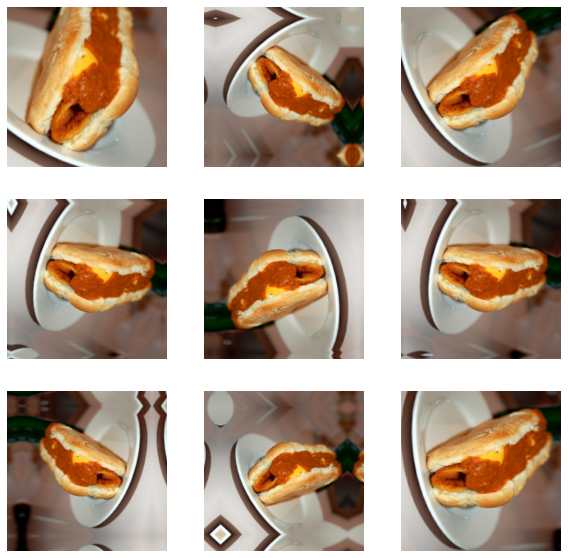

In [29]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

### Rescaling

In [54]:
rescale = preprocessing.Rescaling(1./255)

# Training

## AlexNet

In [55]:
# AlexNet variation implementation with Functional API in Tensorflow 2
def AlexNet():
    inputs = tf.keras.Input(shape=(256, 256, 3), name='image')
    x = data_augmentation(inputs)
    x = rescale(x)
    x = layers.Conv2D(96, (11, 11), strides=4, activation='relu')(x)
    x = layers.MaxPool2D((3, 3), strides=2)(x)
    x = layers.Conv2D(256, (5, 5), strides=1, padding='same', activation='relu')(x)
    x = layers.MaxPool2D((3, 3), strides=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(384, (3, 3), strides=1, padding='same', activation='relu')(x)
    x = layers.Conv2D(384, (3, 3), strides=1, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), strides=1, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((3, 3), strides=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs, name='AlexNet')
    return model

In [56]:
model_alexnet = AlexNet()

In [57]:
model_alexnet.summary()

Model: "AlexNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 62, 62, 96)        34944     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 96)        0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 30, 30, 256)       614656    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 256)       0   

In [17]:
model_alexnet.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [19]:
history_alexnet = model_alexnet.fit(train_dataset,
                    epochs=5,
                    validation_data=validation_dataset)

Epoch 1/5
116/116 [==============================] - 20s 167ms/step - loss: 1.2323 - accuracy: 0.6204 - val_loss: 1.3963 - val_accuracy: 0.6674
Epoch 2/5
116/116 [==============================] - 18s 150ms/step - loss: 0.6423 - accuracy: 0.6755 - val_loss: 1.5310 - val_accuracy: 0.6891
Epoch 3/5
116/116 [==============================] - 18s 151ms/step - loss: 0.5992 - accuracy: 0.6867 - val_loss: 0.5244 - val_accuracy: 0.7098
Epoch 4/5
116/116 [==============================] - 18s 151ms/step - loss: 0.5490 - accuracy: 0.7078 - val_loss: 0.5303 - val_accuracy: 0.7033
Epoch 5/5
116/116 [==============================] - 18s 154ms/step - loss: 0.5289 - accuracy: 0.7214 - val_loss: 3.9273 - val_accuracy: 0.6859


In [21]:
def plotLearningCurve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

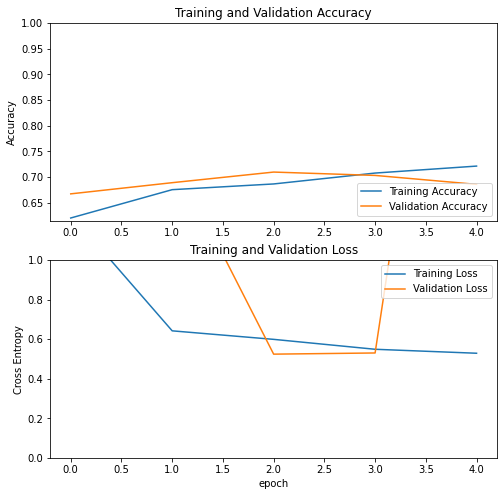

In [21]:
plotLearningCurve(history_alexnet)

## Transfer learning with Pre-Trained VGG19

In [30]:
base_model_vgg19 = tf.keras.applications.vgg19.VGG19(weights = 'imagenet', include_top = False, input_shape = (256,256,3))

In [31]:
base_model_vgg19.trainable = False

In [32]:
inputs = tf.keras.Input(shape=(256, 256, 3), name='image')
x = data_augmentation(inputs)
x = tf.keras.applications.vgg19.preprocess_input(x)
x = base_model_vgg19(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dropout(.3)(x)
outputs = layers.Dense(1)(x)
model_vgg19 = tf.keras.Model(inputs, outputs, name='vgg19')

In [33]:
model_vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 256, 256, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)       0         
_________________________________________________________________
vgg19 (Functional)           (None, 8, 8, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0     

In [34]:
model_vgg19.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [35]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [36]:
history_vgg19 = model_vgg19.fit(train_dataset,
                    epochs=10,
                    validation_data=validation_dataset,
                    callbacks=[callback])

Epoch 1/10
116/116 [==============================] - 64s 545ms/step - loss: 0.7133 - accuracy: 0.8583 - val_loss: 0.1888 - val_accuracy: 0.9489
Epoch 2/10
116/116 [==============================] - 66s 569ms/step - loss: 0.2689 - accuracy: 0.9014 - val_loss: 0.1662 - val_accuracy: 0.9522
Epoch 3/10
116/116 [==============================] - 68s 586ms/step - loss: 0.2126 - accuracy: 0.9156 - val_loss: 0.1659 - val_accuracy: 0.9402
Epoch 4/10
116/116 [==============================] - 69s 591ms/step - loss: 0.2033 - accuracy: 0.9131 - val_loss: 0.1674 - val_accuracy: 0.9467
Epoch 5/10
116/116 [==============================] - 70s 603ms/step - loss: 0.1774 - accuracy: 0.9280 - val_loss: 0.1495 - val_accuracy: 0.9522
Epoch 6/10
116/116 [==============================] - 70s 604ms/step - loss: 0.1758 - accuracy: 0.9221 - val_loss: 0.1730 - val_accuracy: 0.9500
Epoch 7/10
116/116 [==============================] - 70s 607ms/step - loss: 0.1637 - accuracy: 0.9324 - val_loss: 0.1570 - val_ac

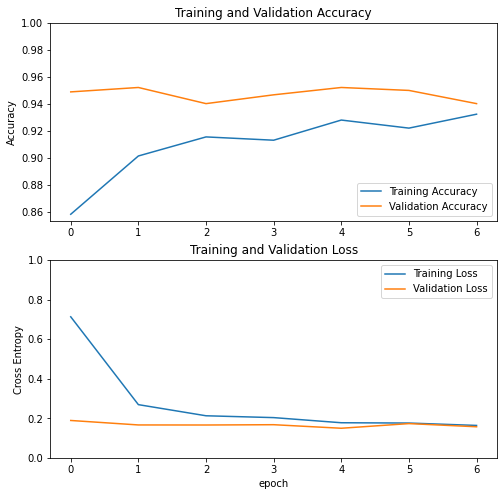

In [37]:
plotLearningCurve(history_vgg19)

In [38]:
model_vgg19.save('model_vgg19.h5')

## Transfer learning with Pre-Trained ResNet50

In [12]:
base_model_resnet50 = tf.keras.applications.resnet50.ResNet50(weights = 'imagenet', include_top = False, input_shape = (256,256,3))

In [13]:
base_model_resnet50.trainable = False

In [14]:
inputs = tf.keras.Input(shape=(256, 256, 3), name='image')
x = data_augmentation(inputs)
x = tf.keras.applications.resnet50.preprocess_input(x)
x = base_model_resnet50(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dropout(.3)(x)
outputs = layers.Dense(1)(x)
model_resnet50 = tf.keras.Model(inputs, outputs, name='resnet50')

In [15]:
model_resnet50.summary()

Model: "resnet50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 256, 256, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0  

In [16]:
model_resnet50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.0005),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [19]:
history_resnet50 = model_resnet50.fit(train_dataset,
                        epochs=10,
                        validation_data=validation_dataset,
                        callbacks=[callback])

Epoch 1/10
116/116 [==============================] - 50s 428ms/step - loss: 0.2275 - accuracy: 0.9085 - val_loss: 0.1211 - val_accuracy: 0.9543
Epoch 2/10
116/116 [==============================] - 48s 413ms/step - loss: 0.1922 - accuracy: 0.9240 - val_loss: 0.1336 - val_accuracy: 0.9446
Epoch 3/10
116/116 [==============================] - 48s 416ms/step - loss: 0.1687 - accuracy: 0.9310 - val_loss: 0.1087 - val_accuracy: 0.9630
Epoch 4/10
116/116 [==============================] - 48s 417ms/step - loss: 0.1571 - accuracy: 0.9400 - val_loss: 0.1308 - val_accuracy: 0.9576
Epoch 5/10
116/116 [==============================] - 49s 420ms/step - loss: 0.1443 - accuracy: 0.9427 - val_loss: 0.1142 - val_accuracy: 0.9587


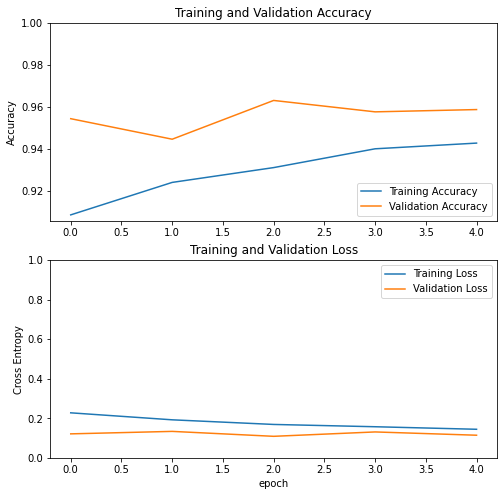

In [22]:
plotLearningCurve(history_resnet50)

In [24]:
model_resnet50.save('model_resnet50.h5')

## Transfer learning with Pre-Trained Inception V3

In [25]:
base_model_inception_v3 = tf.keras.applications.inception_v3.InceptionV3(weights = 'imagenet', include_top = False, input_shape = (256,256,3))

In [26]:
base_model_inception_v3.trainable = False

In [27]:
inputs = tf.keras.Input(shape=(256, 256, 3), name='image')
x = data_augmentation(inputs)
x = tf.keras.applications.inception_v3.preprocess_input(x)
x = base_model_inception_v3(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dropout(.3)(x)
outputs = layers.Dense(1)(x)
model_inception_v3 = tf.keras.Model(inputs, outputs, name='inception_v3')

In [28]:
model_inception_v3.summary()

Model: "inception_v3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 256, 256, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 256, 256, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)             

In [41]:
model_inception_v3.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [38]:
history_inception_v3 = model_inception_v3.fit(train_dataset,
                            epochs=10,
                            validation_data=validation_dataset,
                            callbacks=[callback])

Epoch 1/10
116/116 [==============================] - 33s 284ms/step - loss: 0.1668 - accuracy: 0.9337 - val_loss: 0.1091 - val_accuracy: 0.9587
Epoch 2/10
116/116 [==============================] - 33s 285ms/step - loss: 0.1665 - accuracy: 0.9310 - val_loss: 0.1299 - val_accuracy: 0.9391
Epoch 3/10
116/116 [==============================] - 34s 290ms/step - loss: 0.1613 - accuracy: 0.9337 - val_loss: 0.1077 - val_accuracy: 0.9478
Epoch 4/10
116/116 [==============================] - 34s 292ms/step - loss: 0.1546 - accuracy: 0.9362 - val_loss: 0.1218 - val_accuracy: 0.9413
Epoch 5/10
116/116 [==============================] - 34s 294ms/step - loss: 0.1467 - accuracy: 0.9405 - val_loss: 0.1062 - val_accuracy: 0.9565
Epoch 6/10
116/116 [==============================] - 35s 296ms/step - loss: 0.1501 - accuracy: 0.9365 - val_loss: 0.1064 - val_accuracy: 0.9587
Epoch 7/10
116/116 [==============================] - 35s 297ms/step - loss: 0.1524 - accuracy: 0.9318 - val_loss: 0.1462 - val_ac

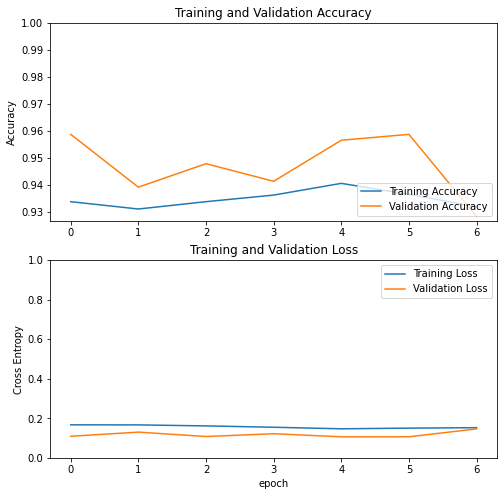

In [39]:
plotLearningCurve(history_inception_v3)

In [40]:
model_inception_v3.save('model_inception_v3.h5')

# Testing

In [9]:
# load the best model
model = tf.keras.models.load_model('model_resnet50.h5')

In [10]:
class_names = ['Hot Dog', 'Not Hot Dog']

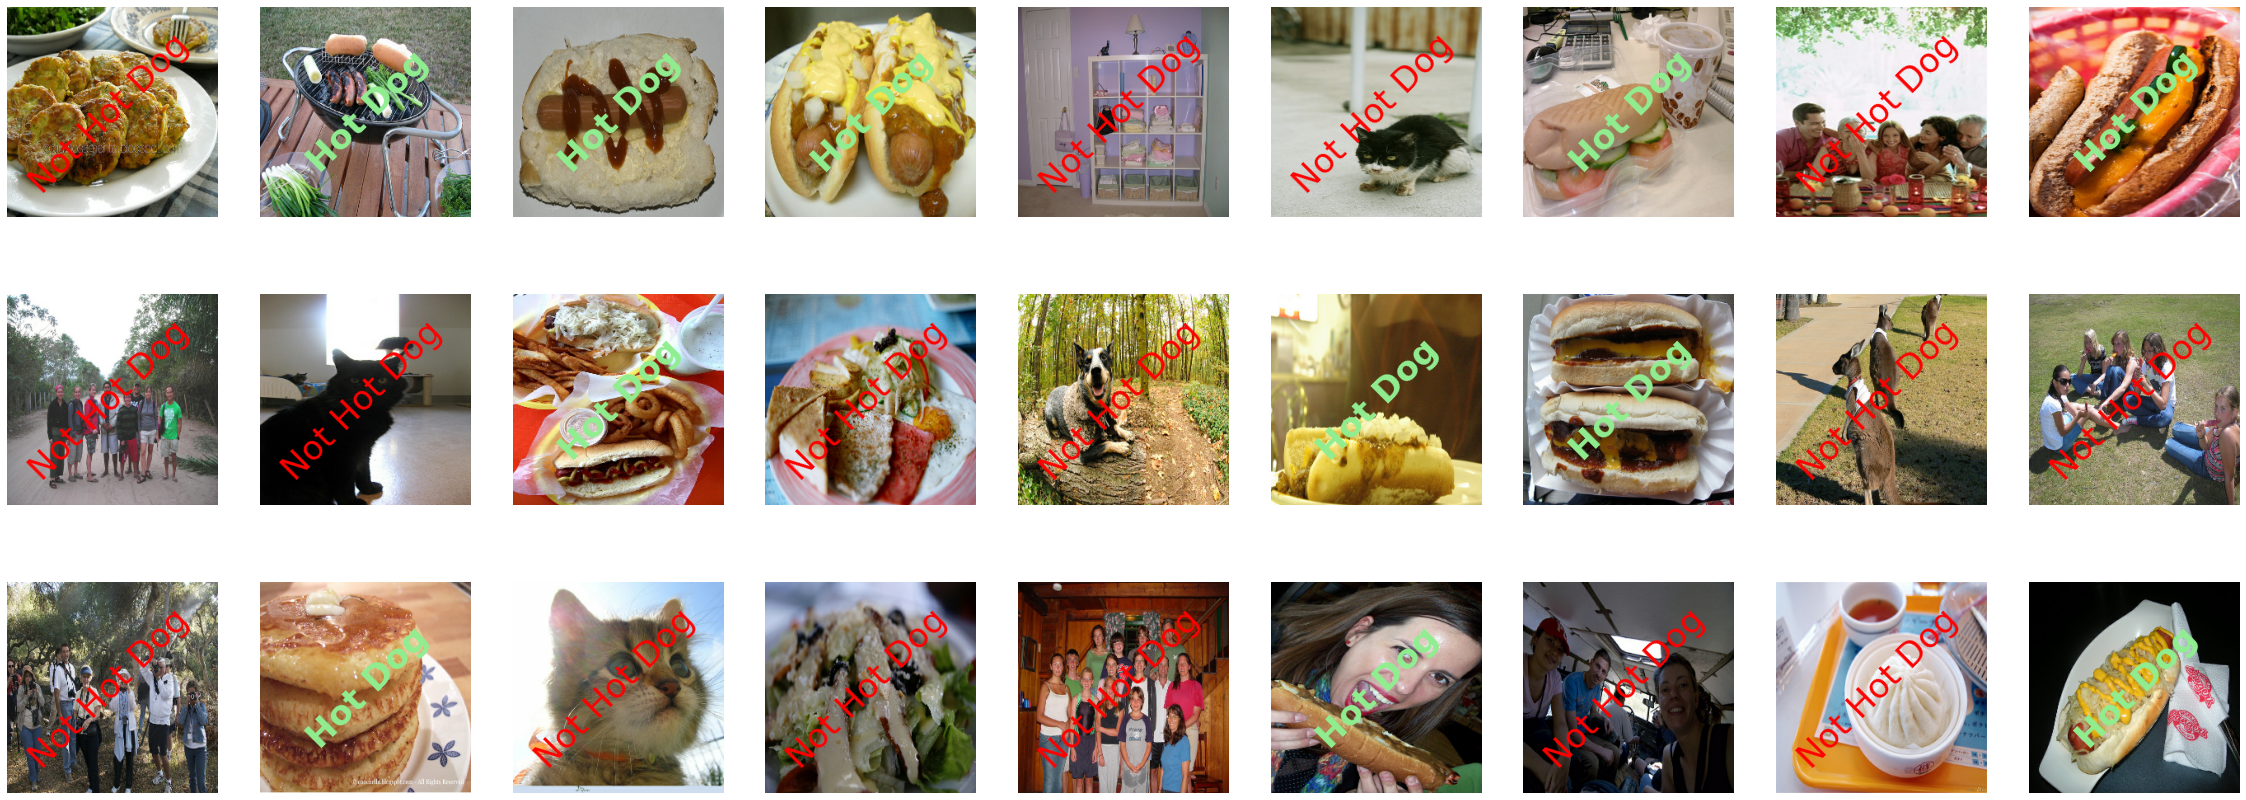

In [25]:
image_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions <= 0.5, 0, 1)

plt.figure(figsize=(40, 15))
for i in range(27):
    ax = plt.subplot(3, 9, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    label = class_names[predictions[i]]
    if label=='Hot Dog':
        plt.text(50, 200, label, rotation=45, color='lightgreen', fontsize=34, fontweight='bold')
    else:
        plt.text(20, 225, label, rotation=45, color='red', fontsize=34, fontweight='normal')
    plt.axis("off")

# References

https://www.tensorflow.org/